## Demo for Estimating Sensitivity for an Experiment
-------
This notebook shows how to simulate the expected sensitivity of an experiment given some specified background(s).

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import darklim

%matplotlib inline

In [5]:
from scipy.special import factorial
import scipy.stats as stats

Text(0.5, 0, 'Energy [eV]')

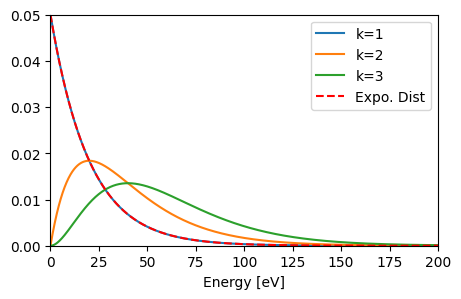

In [6]:
fig, ax = plt.subplots(1,figsize=(5,3))

lam = 1/20.
ks = np.arange(1,4)
x = np.linspace(0,200,2000)

for k in ks:

    dist = stats.erlang.pdf(x,a=k,loc=0,scale=1/lam)
    dist2 = stats.expon.pdf(x,loc=0,scale=1/lam)

    plt.plot(x, dist,label='k={:d}'.format(k))
    
plt.plot(x, dist2,'r--',label='Expo. Dist')
ax.set_xlim(0,200)
ax.set_ylim(0,0.05)
ax.legend(loc='upper right')
ax.set_xlabel('Energy [eV]')

In [7]:
def pile_up_rate(m,n,r,w):
    '''
    given m total devices, each with rate r, calculate the n-fold coincidence rate in a
    coincidence time window of length w.
    r and w must have the same time units, e.g. Hz and seconds
    '''
    #term1 = r
    #term2 = factorial(ndevice)/(ndevice**mfold * factorial(ndevice-mfold))
    #term3 = (r*w)**(mfold-1) * np.exp(r*w) / factorial(mfold-1)
    #return term1*term2*term3
    
    term1 = factorial(m)/factorial(m-n)
    term2 = r**n * w**(n-1)
    return term1*term2

In [7]:
pile_up_rate(2,2,1,100e-6)

0.0002

In [8]:
def exponential_eqn(x_arr, e_0=20, R=0.12):
    '''
    prefactor converts output to evts/keV/day. x_arr now in keV.
    '''
    return 1e3*3600*24 * R * e_0**-1 * np.exp(-1.0*x_arr/(e_0*1e-3))

In [8]:
# define a function to return the n-fold LEE spectrum normalized to the correct rate

def n_fold_lee(x,m=1,n=1,e0=0.020,R=0.12,w=100e-6):
    '''
    e0 has units keV
    R has units 1/seconds
    w, coincidence window, units are seconds
    '''
    
    term1 = factorial(m)/factorial(m-n)
    term2 = R**n * w**(n-1)
    pile_up_rate = term1*term2
    
    dist = pile_up_rate * 3600 * 24 * stats.erlang.pdf(x,a=n,loc=0,scale=e0)
    
    return dist

0-fold coincidence:
integral from 0.001 to 0.5 keV = nan evts/day
= nan evts/s
 
1-fold coincidence:
integral from 0.001 to 0.5 keV = 9.86e+03 evts/day
= 1.14e-01 evts/s
 


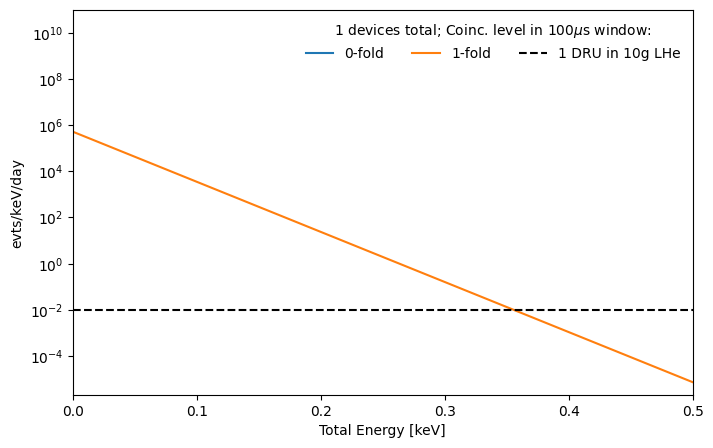

In [11]:
fig, ax = plt.subplots(1,figsize=(8,5))

bins = np.linspace(0.001,0.5,1000)

#exp_model = exponential_eqn(bins)
#integral = np.trapz(exp_model,x=bins)
#print('integral from {} to {} keV = {:.2f} evts/day'.format(bins[0],bins[-1],integral))
#print('= {:0.2} evts/s'.format(integral/24/3600))
#plt.plot(bins,exp_model,'--r')

n_devices = 1
coinc = np.arange(2)
window = 100e-6# s
for n in coinc:
    
    print('{}-fold coincidence:'.format(n))
    model = n_fold_lee(bins,m=n_devices,n=n,e0=0.020,R=0.12,w=window)
    
    integral = np.trapz(model,x=bins)
    print('integral from {} to {} keV = {:.2e} evts/day'.format(bins[0],bins[-1],integral))
    print('= {:0.2e} evts/s'.format(integral/24/3600))
    print(' ')
    
    plt.plot(bins,model,label='{:d}-fold'.format(n))

lhe_mass = 0.010 # kg
ax.axhline(1*lhe_mass,label='1 DRU in 10g LHe'.format(n),color='black',ls='--') # 1 DRU=1 evt/keV/d/kg
#plt.plot(bins,
    
ax.set_ylabel('evts/keV/day')
ax.set_xlabel('Total Energy [keV]')
ax.set_xlim(0,0.5)
ax.set_yscale('log')
ax.set_ylim(None,1e11)
ax.legend(loc='upper right',frameon=False,title='{:d} devices total;'.format(n_devices)+' Coinc. level in {:0.0f}'.format(window*1e6)+r'$\mu$s window:',ncol=3)

Let's define some typical parameters associated with an experiment.

In [3]:
vol_detector = 0.01 * 0.01 * 0.01 # 1 cm^3
time_elapsed = 1 # days of data
efficiency = 1.0 # assume 80% efficiency of cuts/livetime
tm = 'Si' # assume a Silicon target mass

mass_det = darklim.sensitivity.calculate_substrate_mass(vol_detector, tm=tm) # mass of the detector in kg
#mass_det = 1 # mass of the detector in kg
print('detector mass is {} kg = {} g'.format(mass_det,mass_det*1000))
energy_res = 0.373e-3 # energy resolution in keV
threshold = 5 * energy_res # threshold
print('threshold = {:0.1f} eV'.format(threshold*1000))

material density is 2329.6 kg/m3
detector mass is 0.0023296 kg = 2.3295999999999997 g
threshold = 1.9 eV


Use `rqpy.sim.SensEst` to set up the experiment and create some backgrounds.

There are three types backgrounds we can add easily:
1. Flat background (energy independent)
2. Noise background (the expected background from noise events being triggered)
3. DM background (a WIMP background model)

If a different background function is to be inputted, one can use the `rqpy.sim.SensEst.add_arb_bkgd` method.

integral from 0.1 to 100.0 eV = 0.12 evts/s


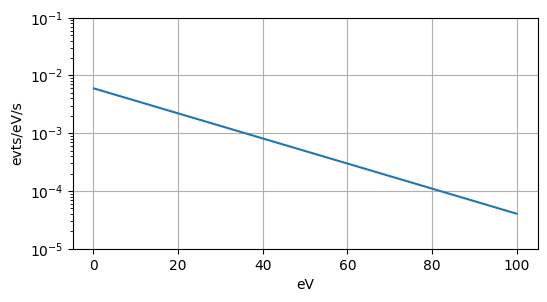

In [16]:
# Roger's LEE model for 1% device:
def exponential_eqn_og(x_arr, e_0=20, R=0.12):
    return R * e_0**-1 * np.exp(-1.0*x_arr/e_0)

fig, ax = plt.subplots(1,figsize=(6,3))
bins = np.linspace(0.1,100,1000)
exp_model_1og = exponential_eqn_og(bins)

plt.plot(bins,exp_model_1og)
plt.ylabel('evts/eV/s')
plt.ylim(1e-5,1e-1)
plt.xlabel('eV')
plt.yscale('log')
plt.grid()

integral = np.trapz(exp_model_1og,x=bins)
print('integral from {} to {} eV = {:.2f} evts/s'.format(bins[0],bins[-1],integral))

In [32]:
# Roger's LEE model for 1% device:
def exponential_eqn(x_arr, e_0=20, R=0.12):
    '''
    old: x_arr is energy bins in units of eV in the phonon system of the 1% detector. returns units of:  events/eV/second
    
    new: 
    prefactor converts output to evts/keV/day. x_arr now in keV.
    '''
    return 1e3*3600*24 * R * e_0**-1 * np.exp(-1.0*x_arr/(e_0*1e-3))


#fig, ax = plt.subplots(1,figsize=(6,4))
#bins = np.linspace(0.0001,0.1,100)
#exp_model_1 = exponential_eqn(bins)
#integral = np.trapz(exp_model_1,x=bins)
#print('integral from {} to {} keV = {:.2f} evts/day'.format(bins[0],bins[-1],integral))
#print('= {:0.2} evts/s'.format(integral/24/3600))

#exp_model_1 = lambda x: exponential_eqn(x) / mass_det

#plt.plot(bins,exp_model_1(bins))
#plt.ylabel('evts/keV/day')
#plt.xlabel('keV')
#plt.yscale('log')

expect 10375.2 evts
created 10376.0 evts


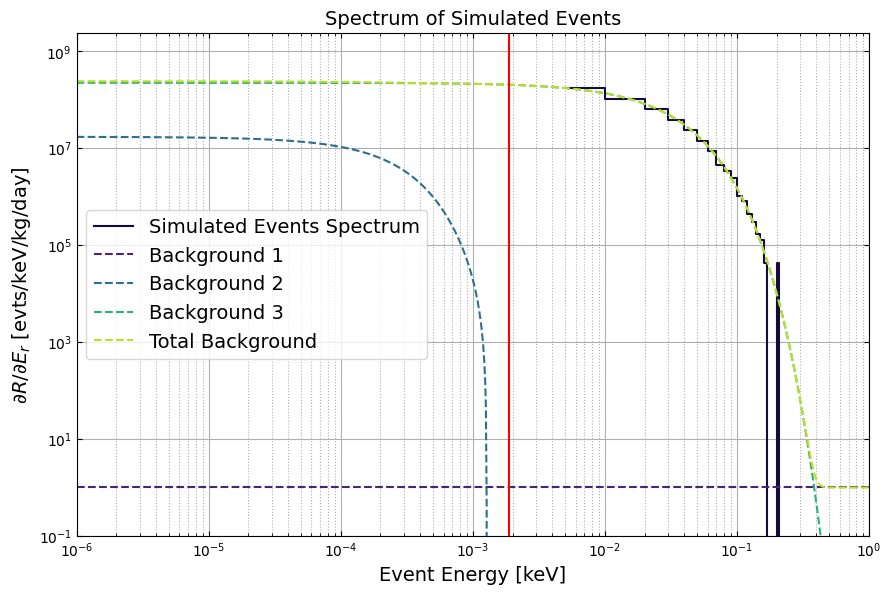

In [12]:
SE = darklim.sensitivity.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)
#SE = darklim.sensitivity.SensEst(mass_det, 10, eff=efficiency, tm=tm)

#SE.reset_sim()

SE.add_flat_bkgd(1) # flat background of 1 DRU

# noise background assuming 1024 independent samples, using the data sample rate
#SE.add_noise_bkgd(energy_res, 1024, 39062.5)

# DM background for 1 GeV dark matter with a cross section of 1e-36 cm^2
SE.add_dm_bkgd(0.05, 1e-38)

exp_model_1 = lambda x: exponential_eqn(x) / mass_det
SE.add_arb_bkgd(exp_model_1)

gen_evts = SE.generate_background(1, plot_bkgd=True)
ax = plt.gca()
#plt.ylim(0.1,50)
ax.set_xscale('log')
ax.axvline(threshold,ls='-',color='red')

In the above figure, we can see the three different backgrounds, the total background, and the data generated.

Below, we'll reset the simulation, remake the backgrounds without including the DM background, and run the simulation.

expect 10367.8 evts
created 10325.0 evts
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax f

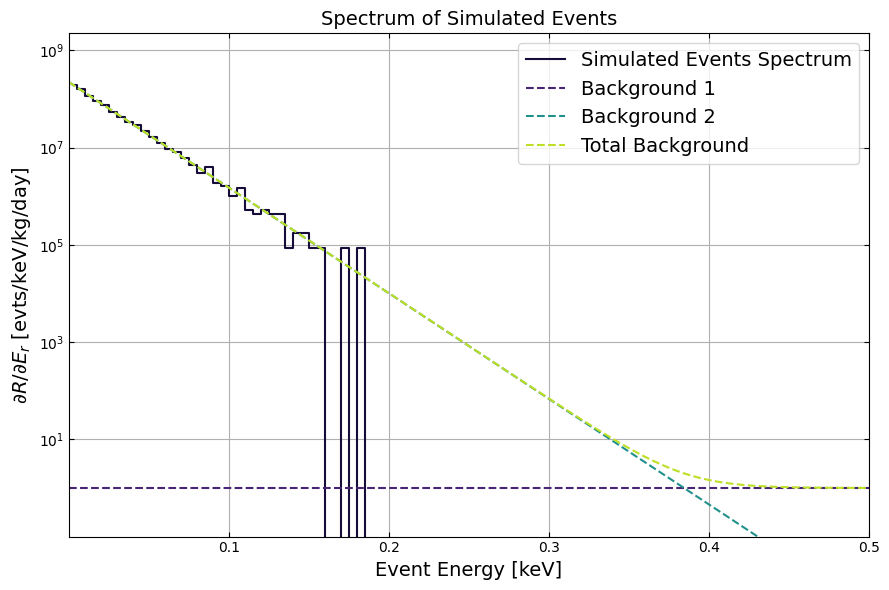

In [13]:
SE.reset_sim()

SE.add_flat_bkgd(1) # flat background of 1 DRU
SE.add_arb_bkgd(exp_model_1)

# run the simulation for 1 experiment
m_dm, sig = SE.run_sim(
    threshold,
    0.5,
    #m_dms=np.geomspace(0.01, 2, num=25),
    m_dms=np.geomspace(0.1, 2, num=10),
    plot_bkgd=True,
    nexp=1, # increase for a better estimate, 1 is generally used for diagnostics
)

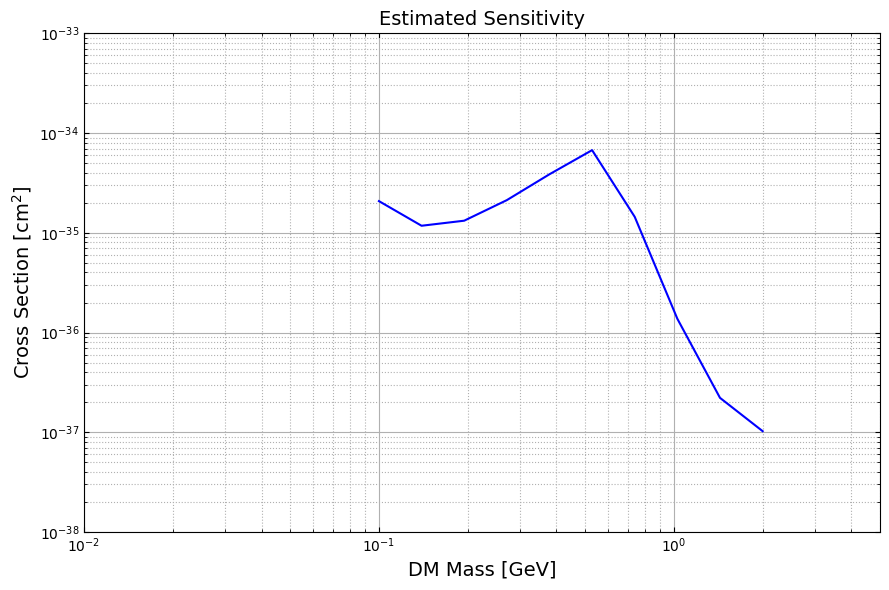

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.loglog(m_dm, sig, color='b')

ax.set_ylim(1e-38, 1e-33)
ax.set_xlim(0.01, 5)
ax.set_xlabel("DM Mass [GeV]", fontsize=14)
ax.set_ylabel("Cross Section [cm$^2$]", fontsize=14)
ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

fig.tight_layout()

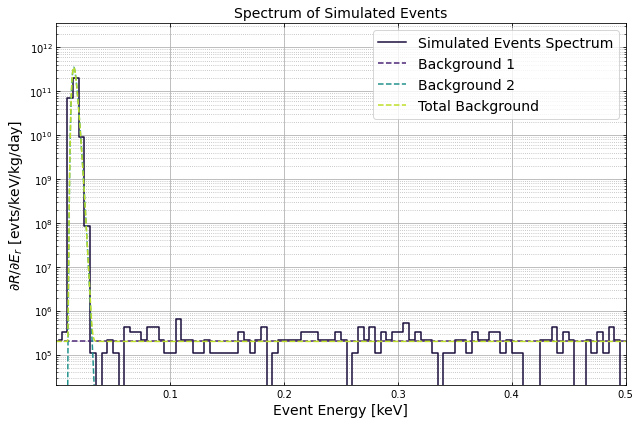

In [4]:
SE.reset_sim()

# flat background of 200000 DRU
SE.add_flat_bkgd(2e5)
# noise background assuming 1024 independent samples, using the data sample rate
SE.add_noise_bkgd(energy_res, 1024, 39062.5)

# run the simulation for 1 experiment
m_dm, sig = SE.run_sim(
    threshold,
    0.5,
    m_dms=np.geomspace(0.01, 2, num=25),
    plot_bkgd=True,
    nexp=1, # increase for a better estimate, 1 is generally used for diagnostics
)

With the simulation run, let's plot the estimated sensitivity for this (imaginary) detector.

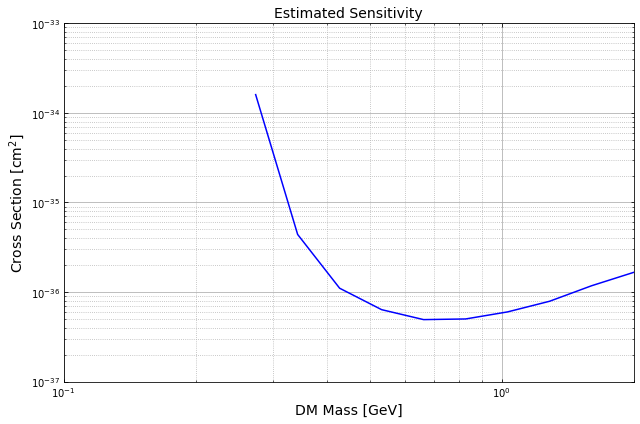

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.loglog(m_dm, sig, color='b')

ax.set_ylim(1e-37, 1e-33)
ax.set_xlim(0.1, 2)
ax.set_xlabel("DM Mass [GeV]", fontsize=14)
ax.set_ylabel("Cross Section [cm$^2$]", fontsize=14)
ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

fig.tight_layout()